<a href="https://colab.research.google.com/github/Bei-Rong/hello-world/blob/master/Copy_of_GradientDescent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Generation

In [2]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

dim_theta = 10
data_num = 1000
scale = .1

theta_true = np.ones((dim_theta,1))
print('True theta:', theta_true.reshape(-1))

A = np.random.uniform(low=-1.0, high=1.0, size=(data_num,dim_theta))
y_data = A @ theta_true + np.random.normal(loc=0.0, scale=scale, size=(data_num, 1))

A_test = np.random.uniform(low=-1.0, high=1.0, size=(50, dim_theta))
y_test = A_test @ theta_true + np.random.normal(loc=0.0, scale=scale, size=(50, 1))

True theta: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Solving for the exact mean squared loss (solving Ax = b)

In [3]:
'''
Hints:
1. See the least squares solution to Ax = b (when it is covered in lecture).

2. Use Numpy functions like Numpy's linear algebra functions to solve for x in Ax = b.
In fact, the linear algebra module is already imported with ```import numpy.linalg as la```.

3. Use the defined variable A in Ax = b. Use y_data as b. Use theta_pred as x.
'''
theta_pred = la.inv(A.T @ A) @ A.T @ y_data # TODO: Implement the analytical solution

print('Empirical theta', theta_pred.reshape(-1))

Empirical theta [1.00191287 1.00059695 0.99805895 0.99833456 1.0013841  0.99942881
 0.99981339 0.99572032 1.00323327 1.01044788]


# SGD Variants Noisy Function

In [4]:
batch_size = 1
max_iter = 1000
lr = 0.001
theta_init = np.random.random((10,1)) * 0.1

In [5]:
def noisy_val_grad(theta_hat, data_, label_, deg_=2.):
    gradient = np.zeros_like(theta_hat)
    loss = 0

    for i in range(data_.shape[0]):
        x_ = data_[i, :].reshape(-1,1)
        y_ = label_[i, 0]
        err = float((x_.T @ theta_hat - y_)[0, 0])

        grad = deg_ * (np.abs(err) ** (deg_ - 1)) * np.sign(err) * x_
        l = (np.abs(err)) ** deg_

        loss += l / data_.shape[0]
        gradient += grad / data_.shape[0]

    return loss, gradient

# Running SGD Variants

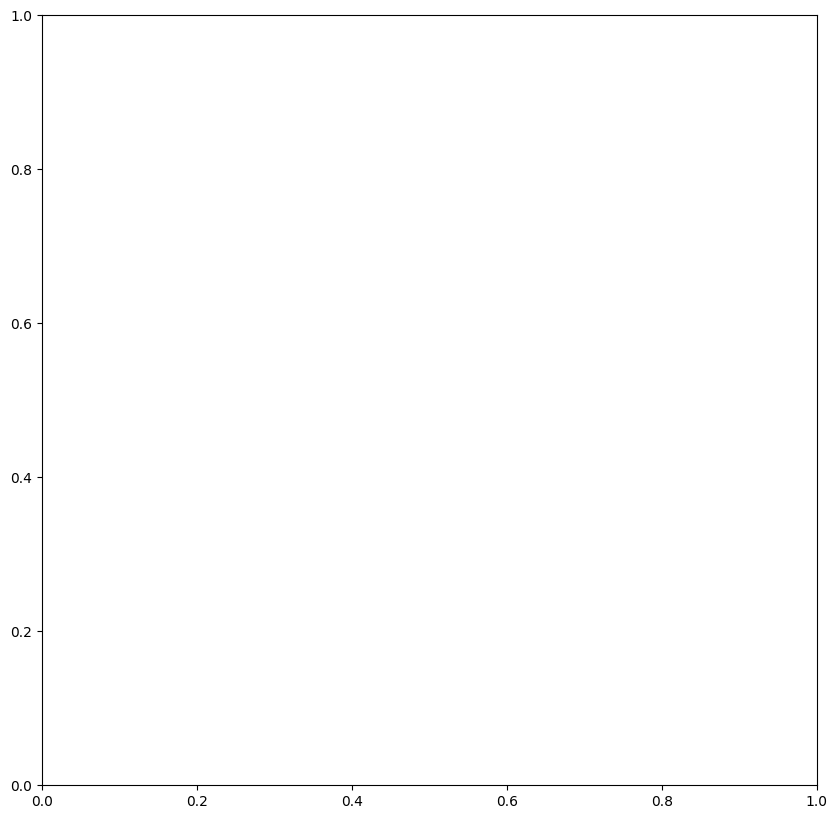

In [6]:
#@title Parameters
deg_ = 2. #@param {type: "number"}
num_rep = 10 #@param {type: "integer"}
max_iter = 1000 #@param {type: "integer"}
fig, ax = plt.subplots(figsize=(10,10))
best_vals = {}
test_exp_interval = 50 #@param {type: "integer"}
grad_artificial_normal_noise_scale = 0. #@param {type: "number"}

adam 0
Final parameters after 1000 updates: [[0.31467382]
 [0.2925498 ]
 [0.3658168 ]
 [0.40431718]
 [0.30724445]
 [0.20519122]
 [0.28697208]
 [0.2354414 ]
 [0.34222035]
 [0.32514498]]
sgd 0
Final parameters after 1000 updates: [[0.54931299]
 [0.5064524 ]
 [0.49536535]
 [0.49326127]
 [0.46758003]
 [0.38559163]
 [0.48101056]
 [0.39402541]
 [0.53284483]
 [0.47819501]]
adagrad 0
Final parameters after 1000 updates: [[0.02007882]
 [0.03308073]
 [0.11174631]
 [0.11956027]
 [0.08437438]
 [0.02852544]
 [0.07194515]
 [0.01518947]
 [0.04138869]
 [0.10735449]]


Text(0.5, 0, 'Updates')

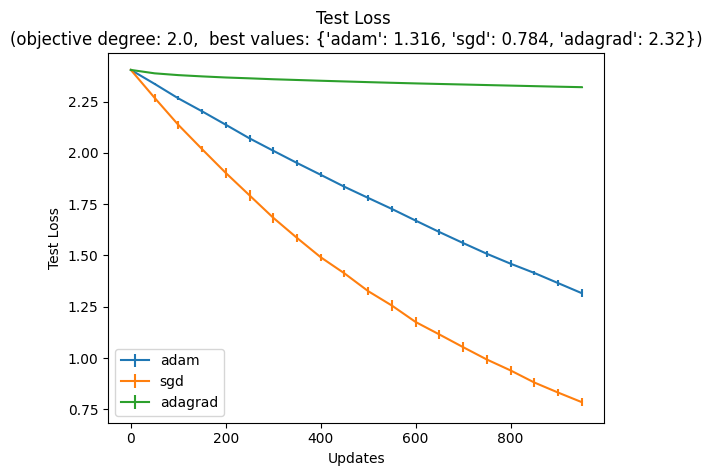

In [7]:
for method_idx, method in enumerate(['adam', 'sgd', 'adagrad']):
    test_loss_mat = []
    train_loss_mat = []

    for replicate in range(num_rep):
        if replicate % 20 == 0:
            print(method, replicate)

        theta_hat = theta_init.copy()

        if method == 'adam':
            beta_1 = 0.9
            beta_2 = 0.999
            m = np.zeros_like(theta_hat)
            v = np.zeros_like(theta_hat)
            epsilon = 1e-8

        if method == 'adagrad':
            epsilon = 1e-8
            squared_sum = np.zeros_like(theta_hat)


        test_loss_list = []
        train_loss_list = []

        for t in range(max_iter):
            idx = np.random.choice(data_num, batch_size) # Split data
            train_loss, gradient = noisy_val_grad(theta_hat, A[idx,:],
                                                  y_data[idx,:], deg_=deg_)
            artificial_grad_noise = np.random.randn(10, 1) * grad_artificial_normal_noise_scale + np.sign(np.random.random((10, 1)) - 0.5) * 0.
            gradient = gradient + artificial_grad_noise
            train_loss_list.append(train_loss)

            if t % test_exp_interval == 0:
                test_loss, _ = noisy_val_grad(theta_hat, A_test[:,:], y_test[:,:], deg_=deg_)
                test_loss_list.append(test_loss)

            if method == 'adam':
                m = beta_1 * m + (1 - beta_1) * gradient
                v = beta_2 * v + (1 - beta_2) * (gradient ** 2)
                m_hat = m / (1 - beta_1 ** (t + 1))
                v_hat = v / (1 - beta_2 ** (t + 1))
                theta_hat = theta_hat - lr * m_hat / (np.sqrt(v_hat) + epsilon)

            elif method == 'adagrad':
                squared_sum += gradient ** 2
                theta_hat = theta_hat - lr * gradient / (np.sqrt(squared_sum) + epsilon)

            elif method == 'sgd':
                theta_hat = theta_hat - lr * gradient

        test_loss_mat.append(test_loss_list)
        train_loss_mat.append(train_loss_list)

    print(f"Final parameters after 1000 updates: {theta_hat}")

    x_axis = np.arange(max_iter)[::test_exp_interval]

    test_loss_np = np.array(test_loss_mat)

    test_loss_mean = np.mean(test_loss_np, axis=0)

    test_loss_se = np.std(test_loss_np, axis=0) / np.sqrt(num_rep)

    plt.errorbar(x_axis, test_loss_mean, yerr=2.5*test_loss_se, label=method)
    best_vals[method] = min(test_loss_mean)

best_vals = { k: int(v * 1000) / 1000. for k,v in best_vals.items() } # A weird way to round numbers
plt.title(f'Test Loss \n(objective degree: {deg_},  best values: {best_vals})')
plt.ylabel('Test Loss')
plt.legend()
plt.xlabel('Updates')

True theta: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Empirical theta [1.00116674 1.00385591 0.98978823 1.00327676 1.00418602 1.00092597
 1.00374912 1.00381648 0.99898869 1.0007498 ]
adam 0
Final parameters after 1000 updates: [[0.16149106]
 [0.1837418 ]
 [0.22039407]
 [0.173222  ]
 [0.1749531 ]
 [0.16677719]
 [0.19800963]
 [0.23631643]
 [0.15132889]
 [0.24246287]]
sgd 0
Final parameters after 1000 updates: [[0.80878885]
 [0.7176506 ]
 [0.80680405]
 [0.95549267]
 [0.77329482]
 [0.78530931]
 [0.88711776]
 [0.80320517]
 [0.94823233]
 [0.91637548]]
adagrad 0
Final parameters after 1000 updates: [[0.07100361]
 [0.03446687]
 [0.0876247 ]
 [0.0540802 ]
 [0.02518851]
 [0.02711566]
 [0.05506599]
 [0.1027305 ]
 [0.02557065]
 [0.08737077]]


Text(0.5, 0, 'Updates')

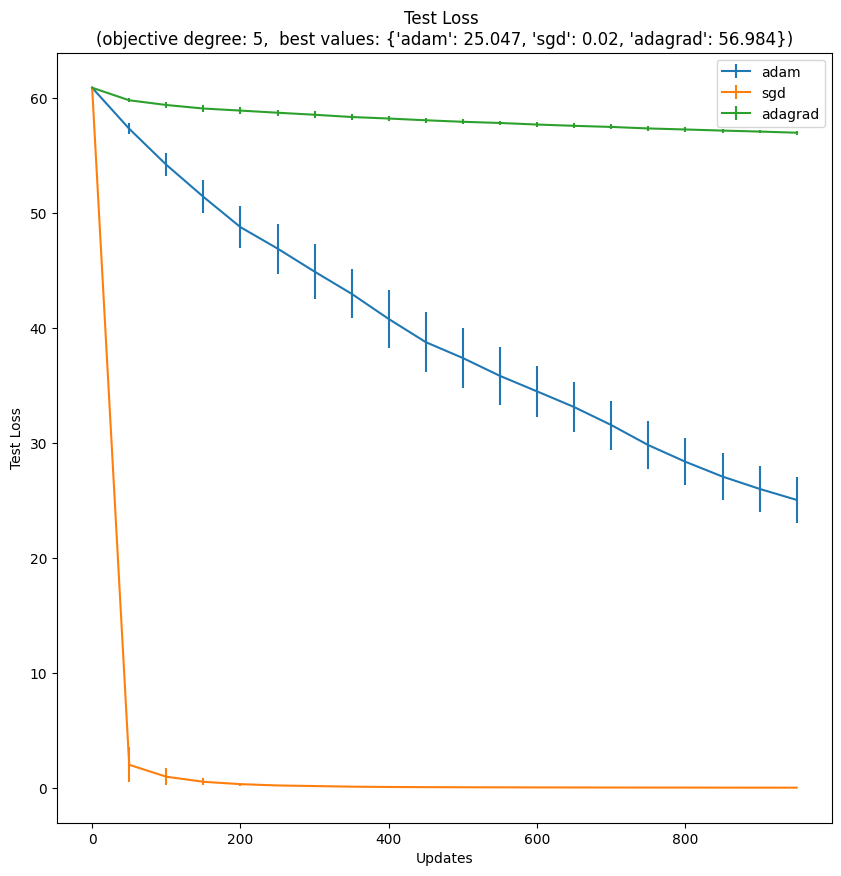

In [8]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

dim_theta = 10
data_num = 1000
scale = .1

theta_true = np.ones((dim_theta,1))
print('True theta:', theta_true.reshape(-1))

A = np.random.uniform(low=-1.0, high=1.0, size=(data_num,dim_theta))
y_data = A @ theta_true + np.random.normal(loc=0.0, scale=scale, size=(data_num, 1))

A_test = np.random.uniform(low=-1.0, high=1.0, size=(50, dim_theta))
y_test = A_test @ theta_true + np.random.normal(loc=0.0, scale=scale, size=(50, 1))


theta_pred = la.inv(A.T @ A) @ A.T @ y_data # TODO: Implement the analytical solution

print('Empirical theta', theta_pred.reshape(-1))

batch_size = 1
max_iter = 1000
lr = 0.001
theta_init = np.random.random((10,1)) * 0.1

def noisy_val_grad(theta_hat, data_, label_, deg_=2.):
    gradient = np.zeros_like(theta_hat)
    loss = 0

    for i in range(data_.shape[0]):
        x_ = data_[i, :].reshape(-1,1)
        y_ = label_[i, 0]
        err = float((x_.T @ theta_hat - y_)[0, 0])

        grad = deg_ * (np.abs(err) ** (deg_ - 1)) * np.sign(err) * x_
        l = (np.abs(err)) ** deg_

        loss += l / data_.shape[0]
        gradient += grad / data_.shape[0]

    return loss, gradient

#@title Parameters
deg_ = 2 #@param {type: "number"}
num_rep = 10 #@param {type: "integer"}
max_iter = 1000 #@param {type: "integer"}
fig, ax = plt.subplots(figsize=(10,10))
best_vals = {}
test_exp_interval = 50 #@param {type: "integer"}
grad_artificial_normal_noise_scale = 0. #@param {type: "number"}

for method_idx, method in enumerate(['adam', 'sgd', 'adagrad']):
    test_loss_mat = []
    train_loss_mat = []

    for replicate in range(num_rep):
        if replicate % 20 == 0:
            print(method, replicate)

        theta_hat = theta_init.copy()

        if method == 'adam':
            beta_1 = 0.9
            beta_2 = 0.999
            m = np.zeros_like(theta_hat)
            v = np.zeros_like(theta_hat)
            epsilon = 1e-8

        if method == 'adagrad':
            epsilon = 1e-8
            squared_sum = np.zeros_like(theta_hat)


        test_loss_list = []
        train_loss_list = []

        for t in range(max_iter):
            idx = np.random.choice(data_num, batch_size) # Split data
            train_loss, gradient = noisy_val_grad(theta_hat, A[idx,:], y_data[idx,:], deg_=deg_)
            artificial_grad_noise = np.random.randn(10, 1) * grad_artificial_normal_noise_scale + np.sign(np.random.random((10, 1)) - 0.5) * 0.
            gradient = gradient + artificial_grad_noise
            train_loss_list.append(train_loss)

            if t % test_exp_interval == 0:
                test_loss, _ = noisy_val_grad(theta_hat, A_test[:,:], y_test[:,:], deg_=deg_)
                test_loss_list.append(test_loss)

            if method == 'adam':
                m = beta_1 * m + (1 - beta_1) * gradient
                v = beta_2 * v + (1 - beta_2) * (gradient ** 2)
                m_hat = m / (1 - beta_1 ** (t + 1))
                v_hat = v / (1 - beta_2 ** (t + 1))
                theta_hat = theta_hat - lr * m_hat / (np.sqrt(v_hat) + epsilon)

            elif method == 'adagrad':
                squared_sum += gradient ** 2
                theta_hat = theta_hat - lr * gradient / (np.sqrt(squared_sum) + epsilon)

            elif method == 'sgd':
                theta_hat = theta_hat - lr * gradient

        test_loss_mat.append(test_loss_list)
        train_loss_mat.append(train_loss_list)

    print(f"Final parameters after 1000 updates: {theta_hat}")

    x_axis = np.arange(max_iter)[::test_exp_interval]

    test_loss_np = np.array(test_loss_mat)

    test_loss_mean = np.mean(test_loss_np, axis=0)

    test_loss_se = np.std(test_loss_np, axis=0) / np.sqrt(num_rep)

    plt.errorbar(x_axis, test_loss_mean, yerr=2.5*test_loss_se, label=method)
    best_vals[method] = min(test_loss_mean)

best_vals = { k: int(v * 1000) / 1000. for k,v in best_vals.items() } # A weird way to round numbers
plt.title(f'Test Loss \n(objective degree: {deg_},  best values: {best_vals})')
plt.ylabel('Test Loss')
plt.legend()
plt.xlabel('Updates')

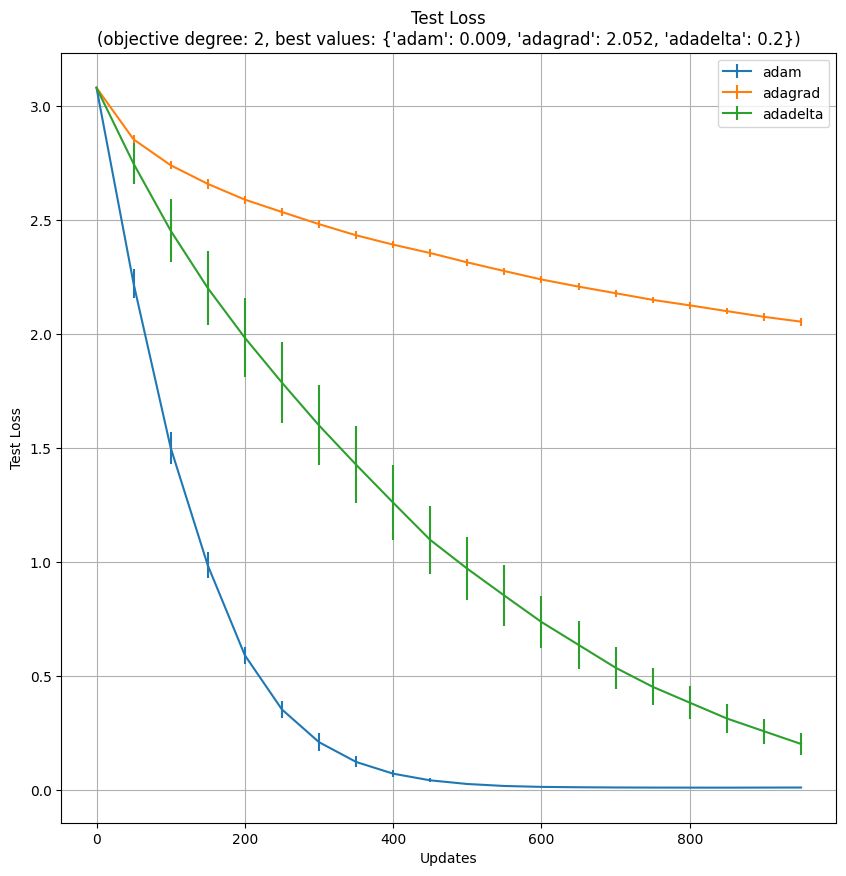

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

# Data generation
dim_theta = 10
data_num = 1000
scale = 0.1

theta_true = np.ones((dim_theta, 1))
A = np.random.uniform(low=-1.0, high=1.0, size=(data_num, dim_theta))
y_data = A @ theta_true + np.random.normal(loc=0.0, scale=scale, size=(data_num, 1))
A_test = np.random.uniform(low=-1.0, high=1.0, size=(50, dim_theta))
y_test = A_test @ theta_true + np.random.normal(loc=0.0, scale=scale, size=(50, 1))

theta_pred = la.inv(A.T @ A) @ A.T @ y_data
theta_init = np.random.random((dim_theta, 1)) * 0.1

# Loss and gradient
def noisy_val_grad(theta_hat, data_, label_, deg_=2.):
    gradient = np.zeros_like(theta_hat)
    loss = 0
    for i in range(data_.shape[0]):
        x_ = data_[i, :].reshape(-1,1)
        y_ = label_[i, 0]
        err = float((x_.T @ theta_hat - y_)[0, 0])
        grad = deg_ * (np.abs(err) ** (deg_ - 1)) * np.sign(err) * x_
        l = (np.abs(err)) ** deg_
        loss += l / data_.shape[0]
        gradient += grad / data_.shape[0]
    return loss, gradient

# Parameters
deg_ = 2
num_rep = 10
max_iter = 1000
test_exp_interval = 50
batch_size = 1
lr = 0.01

fig, ax = plt.subplots(figsize=(10,10))
best_vals = {}

for method in ['adam', 'adagrad', 'adadelta']:
    test_loss_mat = []
    train_loss_mat = []

    for replicate in range(num_rep):
        theta_hat = theta_init.copy()

        if method == 'adam':
            beta_1 = 0.95
            beta_2 = 0.999
            m = np.zeros_like(theta_hat)
            v = np.zeros_like(theta_hat)
            epsilon = 1e-8

        elif method == 'adagrad':
            epsilon = 1e-8
            squared_sum = np.zeros_like(theta_hat)

        elif method == 'adadelta':
            rho = 0.95
            epsilon = 1e-6
            Eg = np.zeros_like(theta_hat)
            Edx = np.zeros_like(theta_hat)

        test_loss_list = []
        train_loss_list = []

        for t in range(max_iter):
            idx = np.random.choice(data_num, batch_size)
            train_loss, gradient = noisy_val_grad(theta_hat, A[idx,:], y_data[idx,:], deg_=deg_)
            train_loss_list.append(train_loss)

            if t % test_exp_interval == 0:
                test_loss, _ = noisy_val_grad(theta_hat, A_test[:,:], y_test[:,:], deg_=deg_)
                test_loss_list.append(test_loss)

            if method == 'adam':
                m = beta_1 * m + (1 - beta_1) * gradient
                v = beta_2 * v + (1 - beta_2) * (gradient ** 2)
                m_hat = m / (1 - beta_1 ** (t + 1))
                v_hat = v / (1 - beta_2 ** (t + 1))
                theta_hat -= lr * m_hat / (np.sqrt(v_hat) + epsilon)

            elif method == 'adagrad':
                squared_sum += gradient ** 2
                theta_hat -= lr * gradient / (np.sqrt(squared_sum) + epsilon)

            elif method == 'adadelta':
                Eg = rho * Eg + (1 - rho) * (gradient ** 2)
                update = -np.sqrt(Edx + epsilon) / np.sqrt(Eg + epsilon) * gradient
                Edx = rho * Edx + (1 - rho) * (update ** 2)
                theta_hat += update

        test_loss_mat.append(test_loss_list)
        train_loss_mat.append(train_loss_list)

    x_axis = np.arange(max_iter)[::test_exp_interval]
    test_loss_np = np.array(test_loss_mat)
    test_loss_mean = np.mean(test_loss_np, axis=0)
    test_loss_se = np.std(test_loss_np, axis=0) / np.sqrt(num_rep)

    plt.errorbar(x_axis, test_loss_mean, yerr=2.5*test_loss_se, label=method)
    best_vals[method] = min(test_loss_mean)

best_vals = {k: int(v * 1000) / 1000. for k,v in best_vals.items()}
plt.title(f'Test Loss\n(objective degree: {deg_}, best values: {best_vals})')
plt.ylabel('Test Loss')
plt.xlabel('Updates')
plt.legend()
plt.grid(True)
plt.show()